<a class="anchor" id="toc"></a>
# Predictions for the z=6 quasar J2310+1855

1. [GMC clumps generator](#clumps)
2. [Extracting the CO SLED](#sled)
3. [Rescaling the X-ray flux](#xrays)
4. [The CO SLED of a GMC](#gmcsled)
5. [XDR CO SLEDs at different radii](#xdrsled)
6. [Radial profiles for CO line ratios](#lineratio)
7. [Comparing different GMCs](#gmccomparison)
8. [Filling the galaxy with GMCs](#gmcspace)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import pandas as pd
from scipy.stats import lognorm
from scipy.interpolate import interp1d

pc = 3.086e18 # cm
msun = 1.99e33 # grams
mp = 1.6726e-24 # grams
kb = 1.38e-16 # erg/K
G = 6.67e-8 # cm^3/g/s^2
lsun = 3.9e33
ry_ev = 13.605698 # eV in 1 Rydberg
ry_nm = 91.1270 # nm in 1 Rydberg
ry_hz = 3.2898e+15 # Hz in 1 Rydberg

sns.set_palette('spring')
sns.set(rc={"figure.dpi":130, 'savefig.dpi':130})
sns.set_style('ticks')
sns.set_style({'xtick.direction': 'in', 'ytick.direction': 'in'})
sns.set_context("paper", rc={"font.size":14, "axes.titlesize":16, "axes.labelsize":16, 'xtick.labelsize':14, 
                             'ytick.labelsize':14, 'xtick.minor.size': 0, 'ytick.minor.size': 0})

# useful functions
def jeans(n, T, mu=1.4, gamma=5/3): # return Jeans radius in pc and mass in Msun
    rho = n * mu * mp
    cs = np.sqrt(gamma * kb * T / (mu * mp))
    RJ = cs * np.sqrt(np.pi / (G * rho))
    MJ = (4/3) * np.pi * rho * RJ**3 / msun
    return RJ/pc, MJ

def closest(series, value): # returns the closest value, then a list of 2 closest inf and sup values
    inf_close = series[series < value].idxmax()
    sup_close = series[series > value].idxmin()
    abs_close = series.iloc[series.sub(value).abs().idxmin()]
    return abs_close, [inf_close, sup_close]

def ovrpdr(wd, filename): # DataFrames of OVR and PDR files for a given Cloudy run
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    ovr = pd.read_csv(wd + subdir + filename + '.ovr', sep='\t')
    pdr = pd.read_csv(wd + subdir + filename + '.pdr', sep='\t')
    return ovr, pdr

def NHcosled(wd, filename, i, Jmax=13, norm=None): # CO SLED of a file at given index i
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    emis = pd.read_csv(wd + subdir + filename + '.emis', sep='\t')
    colist = emis.columns.to_list()[1:31]
    Y = emis[colist[:Jmax]].iloc[i].to_numpy()
    if norm: Y = Y / Y[norm-1]
    return Y

def interSLED(wd, fname, logNH, Jmax=13, norm=0): # interpolated CO SLED for a file given a logNH
    idx = closest(ovrpdr(wd, fname)[1]['H colden'], 10**logNH)[1]
    NHs = [ovrpdr(wd, fname)[1].loc[i, 'H colden'] for i in idx]
    SLEDs = np.array([NHcosled(wd, fname, i, Jmax, norm) for i in idx])
    fits = [interp1d(NHs, SLEDs[:, co], 'linear') for co in range(Jmax)]
    interSLED = np.array([fit(10**logNH) for fit in fits])
    return interSLED

def paramSLED(f1, f2, SLEDs, param): # interpolate SLEDs from f1,f2 files given a param (hden or flux)
    if f1[4:8] == f2[4:8]: # flux case
        params = [float(f[-3:])/1e2 for f in [f1, f2]]
    elif f1[-4:] == f2[-4:]: # density case
        params = [float(f[5:8])/1e2 for f in [f1, f2]]
    fits = [interp1d(params, SLEDs[:, co], 'linear') for co in range(SLEDs.shape[1])]
    paramSLED = np.array([fit(param) for fit in fits])
    return paramSLED

def sww_check(wd, fname, logNH, Jmax=13): # if sww, find existing [f1,f2] and interpolate SLED
    f1, f2 = fname, fname
    sww = pd.read_csv(wd + 'swwlist.csv', header=None)[0].to_list()
    sww = [s.replace('.out', '') for s in sww]
    if fname in sww:
        # find nearby fluxes
        near_check = [True, True]
        while any(near_check):
            if f1 in sww: f1 = f1[:-3] + '{:03d}'.format(int(f1[-3:])-25)
            if f2 in sww: f2 = f2[:-3] + '{:03d}'.format(int(f2[-3:])+25)
            near_check = [f in sww for f in [f1, f2]]
            # breaking conditions
            pdr1 = (fname[:3] == 'pdr') & (int(f1[-3:]) < int((G0[0]+2.8)*1e2))
            pdr2 = (fname[:3] == 'pdr') & (int(f2[-3:]) > int((G0[-1]+2.8)*1e2))
            xdr1 = (fname[:3] == 'xdr') & (int(f1[-3:]) < int((FX[0])*1e2))
            xdr2 = (fname[:3] == 'xdr') & (int(f2[-3:]) > int((FX[-1])*1e2))
            if pdr1 or pdr2 or xdr1 or xdr2:
                print('No more simulations available!', f1, f2)
                break
        SLEDs = np.array([interSLED(wd, f, logNH, Jmax=Jmax) for f in [f1, f2]])
        iSLED = paramSLED(f1, f2, SLEDs, float(fname[-3:])/1e2)
    else:
        iSLED = interSLED(wd, fname, logNH, Jmax=Jmax)
    return f1, f2, iSLED

***
<a class="anchor" id="clumps"></a>

# GMC clumps generator

([back to top](#toc))

In [2]:
# GMC parameters
Mgmc = 1e4 # Msun
Rgmc = 5 * pc # cm
Mach = 20
n0 = 1e3
#rho0 = 2.1e-22
mu = 1.22 # mean molecular weight
#n0 = rho0 / (mu*mp)
rho0 = mu*mp*n0
T = 20 # K
b = 0.3
gamma = 5/3
SigmaGMC = Mgmc / (np.pi*(Rgmc/pc)**2)
print(SigmaGMC)

127.32395447351627


17 extractions
9.87E+03 Msun for a GMC of 1.00E+04 Msun
4.41E+57 cm^3 for a GMC of 1.54E+58 cm^3
The ICM has 1.26E+02 Msun, 1.10E+58 cm^3, 4.47E+00 pc, 1.12E+01 cm^-3
GMC_n1000_R5pc_M20_20K


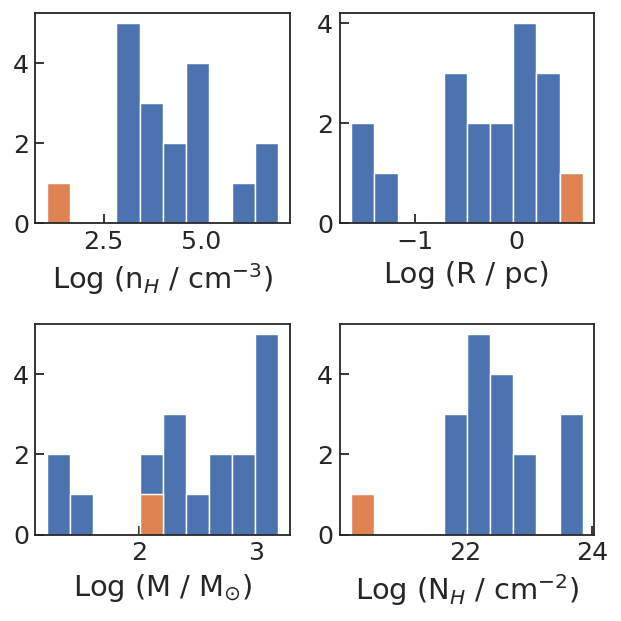

In [267]:
save_df = True

# mass-weighted extractions
Mtot = 0.
sigma = np.log(1 + b**2 * Mach**2)
n, R, M, NH = [], [], [], []
while Mtot < Mgmc:
    rng = np.random.default_rng()
    n1 = rng.lognormal(mean=np.log(n0), sigma=sigma)
    if n1 > n0:
        n.append(n1)
        R.append(jeans(n[-1], T, mu, gamma)[0])
        M.append(jeans(n[-1], T, mu, gamma)[1])
        NH.append(n[-1] * R[-1] * pc)
        Mtot += M[-1]
n, R, M, NH = np.array(n[:-2]), np.array(R[:-2]), np.array(M[:-2]), np.array(NH[:-2])
Mtot = M.sum()
print(len(n), 'extractions')
print('%.2E' % Mtot + ' Msun for a GMC of ' + '%.2E' % Mgmc + ' Msun')

# volumes
Vgmc = (4/3) * np.pi * Rgmc**3
Vtot = np.sum((4/3) * np.pi * (R*pc)**3)
print('%.2E' % Vtot + ' cm^3 for a GMC of ' + '%.2E' % Vgmc + ' cm^3')

# ICM properties
Micm = Mgmc - Mtot
Vicm = Vgmc - Vtot
Ricm = (Vicm * 3/(4*np.pi))**(1/3) / pc
nicm = Micm*msun / (mu*mp*Vicm)
print('The ICM has', '%.2E' % Micm, 'Msun,', '%.2E' % Vicm, 'cm^3,', 
      '%.2E' % Ricm, 'pc,', '%.2E' % nicm, 'cm^-3')

# add ICM to the clump ndf
M = np.append(M, Micm)
R = np.append(R, Ricm)
n = np.append(n, nicm)
NH = np.append(NH, nicm*Ricm*pc)

# plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(5,5))
_, bins, patches = ax1.hist(np.log10(n))
ax1.hist(np.log10(n[-1]), bins=bins)
ax1.set_xlabel(r'Log (n$_H$ / cm$^{-3}$)')
_, bins, patches = ax2.hist(np.log10(R))
ax2.hist(np.log10(R[-1]), bins=bins)
ax2.set_xlabel('Log (R / pc)')
_, bins, patches = ax3.hist(np.log10(M))
ax3.hist(np.log10(M[-1]), bins=bins)
ax3.set_xlabel(r'Log (M / M$_{\odot}$)')
_, bins, patches = ax4.hist(np.log10(NH))
ax4.hist(np.log10(NH[-1]), bins=bins)
ax4.set_xlabel(r'Log (N$_H$ / cm$^{-2}$)')
fig.tight_layout();

# export results
ndf = pd.DataFrame({
    'hden': np.log10(n),  # cm-3
    'logR': np.log10(R),  # pc
    'logM': np.log10(M),  # Msun
    'logNH': np.log10(NH) # cm-2
    })
dfname = 'GMC_n' + str(int(n0)) + '_R' + str(int(Rgmc/pc)) + 'pc_M' + str(int(Mach)) + '_' + str(int(T)) + 'K'
print(dfname)

if save_df: ndf.to_csv('./J2310/' + dfname + '.csv', index=False)

***
<a class="anchor" id="sled"></a>

# Extracting the CO SLED

([back to top](#toc))

In [269]:
# CLOUDY simulations parameters
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
hden, G0, FX = np.arange(1, 6.75, 0.25), np.arange(-2.8, 3.25, 0.25), np.arange(-1, 4.2, 0.25)

# list the available extractions
for f in sorted(os.listdir('./J2310/')): print(f)

# choose GMC extractions and Cloudy grid
ndf_name = 'GMC_n1000_R5pc_M20_20K'
ndf = pd.read_csv('./J2310/' + ndf_name + '.csv')
wd = wd2

GMC_n1000_R5pc_M20_20K.csv
GMC_n102_R16pc_M20_10K.csv
GMC_n102_R16pc_M20_20K
GMC_n102_R16pc_M20_20K.csv
GMC_n300_R15pc_M10_20K
GMC_n300_R15pc_M10_20K.csv
J2310_Tadaki_v20220315.pdf


In [270]:
# PDR
Jmax = 30
for k in range(len(ndf)):
    # dataframe for save_csv of this extraction's CO SLED
    extract = pd.DataFrame(index=['g' + ('%.2f' % (g + 2.8)).replace('.', '') for g in G0],
                           columns=['CO' + str(c) for c in np.arange(1,Jmax+1)])
    # take values from the PDF extraction 
    logn = ndf.loc[k, 'hden']
    logNH = ndf.loc[k, 'logNH']
    # list inferior and superior closest log(n)
    if logn <= hden[-1]:
        hh = [hden[hden < logn].max(), hden[hden > logn].min()]
        for g in range(len(G0)):
            gname = '_g' + ('%.2f' % (G0[g] + 2.8)).replace('.', '')
            # for every G0: list the 2 files for the 2 closest gas densities
            ff = ['pdr_h' + ('%.2f' % h).replace('.', '') + gname for h in hh]
            # for those 2 nH: generate interpolated (logNH, G0 if needed) SLED
            Hsleds = np.array([sww_check(wd, fname, logNH, Jmax=Jmax)[2] for fname in ff])
            # interpolated (logn) SLED
            thisSLED = paramSLED(ff[0], ff[1], Hsleds, logn)
            extract.loc[gname.replace('_', '')] = np.array(thisSLED)
    else:
        for g in range(len(G0)):
            thisSLED = np.zeros(Jmax)
            gname = '_g' + ('%.2f' % (G0[g] + 2.8)).replace('.', '')
            extract.loc[gname.replace('_', '')] = np.array(thisSLED)
    extract.to_csv('./J2310/' + ndf_name + '_' + 'PDR{:04d}'.format(k) + '.csv')

In [271]:
# XDR
Jmax = 30
for k in range(len(ndf)):
    # dataframe for save_csv of this extraction's CO SLED
    extract = pd.DataFrame(index=['x' + ('%.2f' % x).replace('.', '') for x in FX],
                           columns=['CO' + str(c) for c in np.arange(1,Jmax+1)])
    # take values from the PDF extraction 
    logn = ndf.loc[k, 'hden']
    logNH = ndf.loc[k, 'logNH']
    # list inferior and superior closest log(n)
    if logn <= hden[-1]:
        hh = [hden[hden < logn].max(), hden[hden > logn].min()]
        for x in FX:
            xname = '_x' + ('%.2f' % x).replace('.', '')
            # for every FX: list the 2 files for the 2 closest gas densities
            ff = ['xdr_h' + ('%.2f' % h).replace('.', '') + xname for h in hh]
            # for those 2 nH: generate interpolated (logNH, G0 if needed) SLED
            Hsleds = np.array([sww_check(wd, fname, logNH, Jmax=Jmax)[2] for fname in ff])
            # interpolated (logn) SLED
            thisSLED = paramSLED(ff[0], ff[1], Hsleds, logn)
            extract.loc[xname.replace('_', '')] = np.array(thisSLED)
    else:
        for x in FX:
            thisSLED = np.zeros(Jmax)
            xname = '_x' + ('%.2f' % x).replace('.', '')
            extract.loc[xname.replace('_', '')] = np.array(thisSLED)
    extract.to_csv('./J2310/' + ndf_name + '_' + 'XDR{:04d}'.format(k) + '.csv')

***
<a class="anchor" id="xrays"></a>
# Rescaling the X-ray flux

([back to top](#toc))

In [3]:
cont = pd.read_csv('/media/phd/cloudy/ngmgrid/xdr_h100/xdr_h100_x000.cont', sep='\t')
ry_ev = 13.605698
cont.columns

Index(['#Cont  nu', 'incident', 'trans', 'DiffOut', 'net trans', 'reflc',
       'total', 'reflin', 'outlin', 'lineID', 'cont', 'nLine'],
      dtype='object')

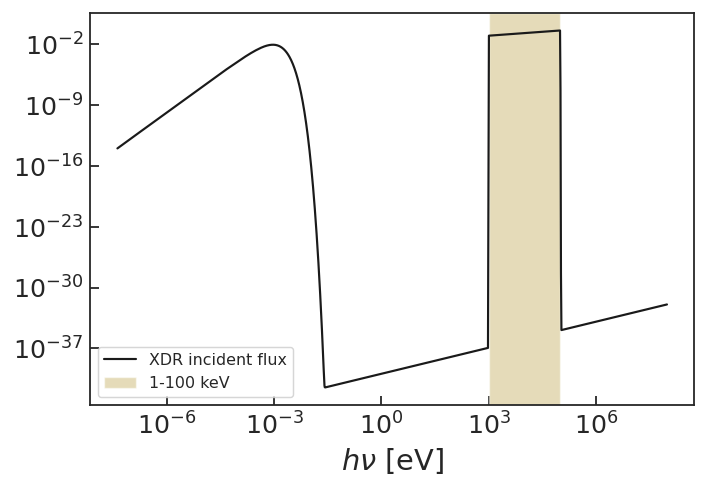

In [4]:
plt.loglog(cont['#Cont  nu']*ry_ev, cont['incident'], label='XDR incident flux', c='k')
plt.xlabel(r'$h\nu$ [eV]')
plt.axvspan(xmin=1e3, xmax=100e3, alpha=.5, fc='y', label='1-100 keV')
plt.legend();

In [5]:
# peak of XDR incident flux is near 100 keV
imax = cont['incident'].idxmax()
print('Peak flux at energy', round(cont.loc[imax, '#Cont  nu']*ry_ev/1e3, 2), 'keV')
norm_flux = cont.loc[imax, 'incident']
norm_keV = cont.loc[imax, '#Cont  nu']*ry_ev/1e3

Peak flux at energy 98.01 keV


If the flux is $F \propto E^{-\gamma}$, and we know that $F(E_1) = F_1$ and $F(E_2) = F_2$,
we can derive $\gamma$:

$$\large
\frac{F_1}{F_2} = \left( \frac{E_1}{E_2} \right)^{-\gamma} \; \; \; \Rightarrow \; \; \;
\log{(F_1 / F_2)} = - \gamma \, \log{(E_1/E_2)} \; \; \; \Rightarrow \; \; \;
\gamma = - \frac{\log{(F_1 / F_2)}}{\log{(E_1/E_2)}}
$$

In [6]:
i1, i2 = imax, imax-100
F1, F2 = cont.loc[[i1, i2], 'incident']
E1, E2 = cont.loc[[i1, i2], '#Cont  nu']
gamma = - np.log10(F1/F2) / np.log10(E1/E2)
propto = F2 / ((E2*ry_ev/1e3)**(-gamma))
print('gamma =', round(gamma, 4))

gamma = -0.2999


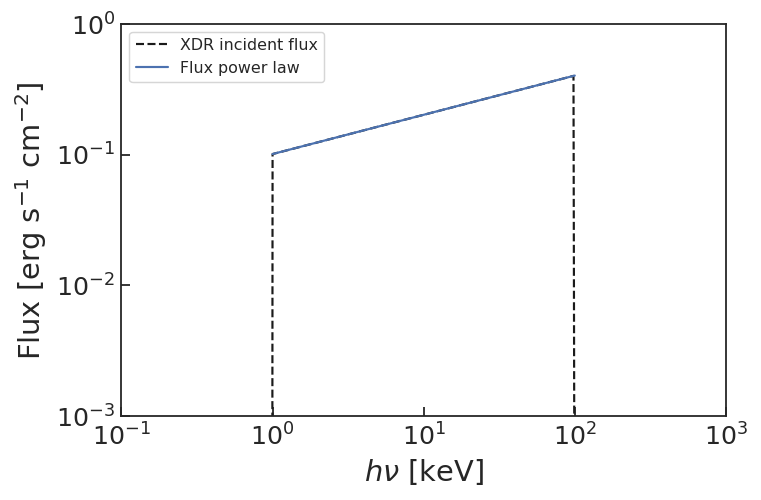

In [7]:
kevs = np.arange(1, 100, 0.01)
flus = propto * (kevs**(-gamma))

plt.loglog(cont['#Cont  nu']*13.605698e-3, cont['incident'], label='XDR incident flux', c='k', ls='--')
plt.loglog(kevs, flus, label='Flux power law')
plt.xlabel(r'$h\nu$ [keV]')
plt.ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$]')
plt.xlim(1e-1, 1e3)
plt.ylim([1e-3, 1e0])
plt.legend();

In [79]:
gmm = 0.3
print((10**gmm - 2**gmm) / (100**gmm - 1**gmm))
#print((10**gmm - 2**gmm)*propto)
#print((100**gmm - 1**gmm)*propto)

0.25632322100982047


If the index is 0.3, so that $E \, F(E) \propto E^{0.3}$, the conversion between the fluxes at 1-100 keV and 2-20 keV is equal to the ratio between the integrals on those ranges:

$$\large
F(\mbox{1-100 keV}) \propto \int_1^{100} E^{-0.7} dE \propto [100^{0.3} - 1^{0.3}] \\ \large
F(\mbox{2-10 keV}) \propto \int_2^{10} E^{-0.7} dE \propto [10^{0.3} - 2^{0.3}] \\ \large
\frac{F(\mbox{2-10 keV})}{F(\mbox{1-100 keV})} = \frac{10^{0.3} - 2^{0.3}}{100^{0.3} - 1^{0.3}} \approx 0.256
$$

In [89]:
# check F(2-10)/F(1-100) ratio value
id1 = (cont['#Cont  nu']*ry_ev*1e-3 - 1).abs().argsort()[:1].values[0]
id2 = (cont['#Cont  nu']*ry_ev*1e-3 - 2).abs().argsort()[:1].values[0]
id10 = (cont['#Cont  nu']*ry_ev*1e-3 - 10).abs().argsort()[:1].values[0]
id100 = (cont['#Cont  nu']*ry_ev*1e-3 - 100).abs().argsort()[:1].values[0]
print(cont.loc[[id1, id2, id10, id100], '#Cont  nu']*ry_ev*1e-3)

print('\n1-100 keV = ', id100+1-id1, 'lines ; 2-10 keV = ', id10+1-id2, 'lines')

flux_1_100 = cont[id1:id100+1]['incident'].sum()
flux_2_10 = cont[id2:id10+1]['incident'].sum()
F1, F2, F10, F100 = cont.loc[[id1,id2,id10,id100]]['incident']
print('\nF(2-10 keV)/F(1-100 keV) =', round((flux_2_10 / flux_1_100), 4))
print('F(2-10 keV)  =', round(flux_2_10, 3), 'erg/s/cm^2')
print('F(1-100 keV) =', round(flux_1_100, 3), 'erg/s/cm^2')
print('[F(10 keV) - F(2 keV)] / [F(100 keV) - F(1 keV)] =', round(((F10-F2)/(F100-F1)), 4))

7176      1.000348
7384      2.000949
7867     10.008964
7998    100.991831
Name: #Cont  nu, dtype: float64

1-100 keV =  823 lines ; 2-10 keV =  484 lines

F(2-10 keV)/F(1-100 keV) = 0.5772
F(2-10 keV)  = 77.255 erg/s/cm^2
F(1-100 keV) = 133.841 erg/s/cm^2
[F(10 keV) - F(2 keV)] / [F(100 keV) - F(1 keV)] = -0.7639


In [80]:
# lines in 1-100 or 2-10 keV range, adding one at both endings
kev1_100 = cont['#Cont  nu'][id1-1:id100+2].to_numpy()*ry_ev*1e-3
kev2_10 = cont['#Cont  nu'][id2-1:id10+2].to_numpy()*ry_ev*1e-3

# median points between every frequencies
kev1_100_meds = np.array([0.5*(kev1_100[i] + kev1_100[i+1]) for i in range(len(kev1_100)-1)])
kev2_10_meds = np.array([0.5*(kev2_10[i] + kev2_10[i+1]) for i in range(len(kev2_10)-1)])

# width of every frequency bin in 1-100 or 2-10 keV range
kev1_100_widths = np.diff(kev1_100_meds)
kev2_10_widths = np.diff(kev2_10_meds)

# multiply flux ratios for bandwidths
flux_1_100_weighted = np.sum(cont[id1:id100+1]['incident'].to_numpy() * kev1_100_widths)
flux_2_10_weighted = np.sum(cont[id2:id10+1]['incident'].to_numpy() * kev2_10_widths)
print('F(2-10)/F(1-100) =', round((flux_2_10_weighted / flux_1_100_weighted), 4))

F(2-10)/F(1-100) = 0.0445


***
<a class="anchor" id="gmcsled"></a>

# GMC CO SLED

([back to top](#toc))

In [284]:
ndf_name = 'GMC_n1000_R5pc_M20_20K'
wd = './J2310/' + ndf_name + '/'
ndf = pd.read_csv('./J2310/' + ndf_name + '.csv')
pdr_df, xdr_df = [], []
for f in sorted(os.listdir(wd)):
    this_extra = pd.read_csv(wd + f, index_col=0)
    logR_cm = ndf.loc[int(f[-6:-4]), 'logR'] + np.log10(pc)
    if 'PDR' in f: pdr_df.append(this_extra * 2*np.pi*(10**logR_cm)**2 / lsun)
    if 'XDR' in f: xdr_df.append(this_extra * 2*np.pi*(10**logR_cm)**2 / lsun)

pdr_gmc = sum(pdr_df)
xdr_gmc = sum(xdr_df)

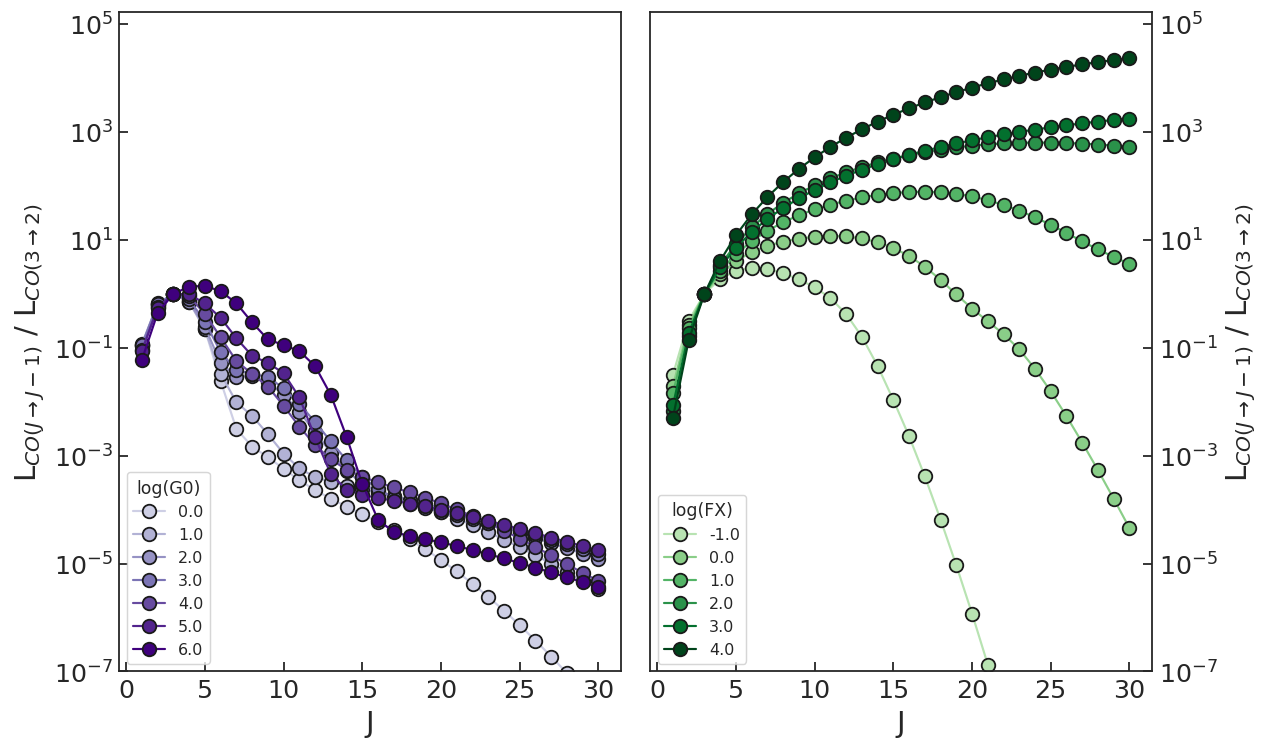

In [285]:
# 0 if no normalization, 1 for CO(1-0), 6 for CO(6-5), etc
norm = 3
Jmax = 30
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharey=True)

color = cm.Purples(np.linspace(0.3, 1, len(pdr_gmc.index[::4])))
for g, c in zip(pdr_gmc.index[::4], color):
    if norm: denom = pdr_gmc.loc[g, pdr_gmc.columns[norm-1]]
    else: denom = 1.
    ax1.plot(np.arange(1,Jmax+1), (pdr_gmc.loc[g]/denom)[:Jmax],
            marker='.', ms=15, mec='k', color=c,
            label=float(g[1:])/1e2)
ax1.legend(title='log(G0)', loc='lower left')

color = cm.Greens(np.linspace(0.3, 1, len(xdr_gmc.index[::4])))
for x, c in zip(xdr_gmc.index[::4], color):
    if norm: denom = xdr_gmc.loc[x, xdr_gmc.columns[norm-1]]
    else: denom = 1.
    ax2.plot(np.arange(1,Jmax+1), (xdr_gmc.loc[x]/denom)[:Jmax],
            marker='.', ms=15, mec='k', color=c,
            label=float(x[1:])/1e2)
ax2.legend(title='log(FX)', loc='lower left')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.yaxis.set_tick_params(labelright=True)

for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(0,Jmax+1)[::5])
    ax.set_yscale('log')
    ax.set_xlabel('J')
    ax.set_ylim(bottom=1e-7)
    if norm:
        nlab = r'L$_{{CO({} \rightarrow {})}}$'.format(norm, norm-1)
        ax.set_ylabel(r'L$_{CO(J \rightarrow J-1)}$ / ' + nlab)
    else:
        ax.set_ylabel(r'L$_{CO(J \rightarrow J-1)}$ [L$_{\odot}$]')

plt.tight_layout();

***
<a class="anchor" id="xdrsled"></a>

# XDR CO SLED at different radii
([back to top](#toc))

For a quasar (J2310+1855) of $L_X = 7 \times 10^{44}$ erg s$^{-1}$, the different $F_X$ correspond to different radii $r_g$, i.e. the distance between the X-ray source and the gas cloud: $r_g = \sqrt{L_X / (4 \pi F_X)}$

In [120]:
ndf_name = 'GMC_n300_R15pc_M10_20K'
wd = './J2310/' + ndf_name + '/'
ndf = pd.read_csv('./J2310/' + ndf_name + '.csv')
pdr_df, xdr_df = [], []
for f in sorted(os.listdir(wd)):
    this_extra = pd.read_csv(wd + f, index_col=0)
    logR_cm = ndf.loc[int(f[-6:-4]), 'logR'] + np.log10(pc)
    if 'PDR' in f: pdr_df.append(this_extra * 2*np.pi*(10**logR_cm)**2 / lsun)
    if 'XDR' in f: xdr_df.append(this_extra * 2*np.pi*(10**logR_cm)**2 / lsun)

pdr_gmc = sum(pdr_df)
xdr_gmc = sum(xdr_df)

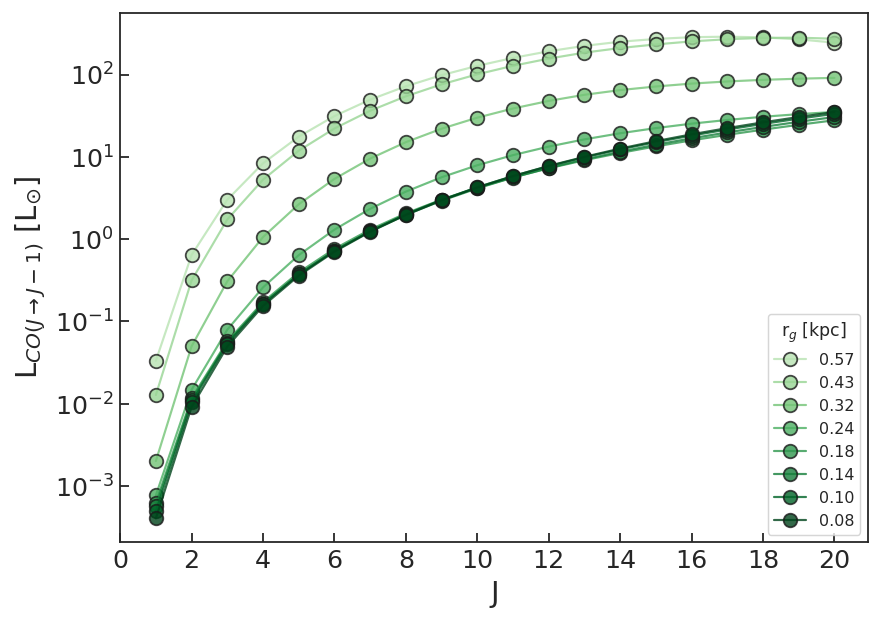

In [22]:
# 0 if no normalization, 1 for CO(1-0), 6 for CO(6-5), etc
norm = 0
Jmax = 20
LX = 7e44
xdrlist = xdr_gmc.index[9:-4]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

color = cm.Greens(np.linspace(0.3, 1, len(xdrlist)))
for x, c in zip(xdrlist, color):
    logFX = float(x[1:])/1e2
    r_g = np.sqrt(LX / (4 * np.pi * 10**logFX))
    if norm: denom = xdr_gmc.loc[x, xdr_gmc.columns[norm-1]]
    else: denom = 1.
    ax2.plot(np.arange(1,Jmax+1), (xdr_gmc.loc[x]/denom)[:Jmax],
            marker='.', ms=15, mec='k', color=c, alpha=.8,
            label='%.2f' % (1e-3*r_g/pc))
ax2.legend(title=r'r$_g$ [kpc]', loc='lower right')

ax2.set_xticks(np.arange(0,Jmax+1)[::2])
ax2.set_yscale('log')
ax2.set_xlabel('J')
if norm:
    nlab = r'L$_{{CO({} \rightarrow {})}}$'.format(norm, norm-1)
    ax2.set_ylabel(r'L$_{CO(J \rightarrow J-1)}$ / ' + nlab)
else:
    ax2.set_ylabel(r'L$_{CO(J \rightarrow J-1)}$ [L$_{\odot}$]')

plt.tight_layout();

***
<a class="anchor" id="lineratio"></a>

# Radial profiles for some CO ratios

([back to top](#toc))

In [3]:
ndf_name = 'GMC_n300_R15pc_M10_20K'
wd = './J2310/' + ndf_name + '/'
ndf = pd.read_csv('./J2310/' + ndf_name + '.csv')
pdr_df, xdr_df = [], []
for f in sorted(os.listdir(wd)):
    this_extra = pd.read_csv(wd + f, index_col=0)
    logR_cm = ndf.loc[int(f[-6:-4]), 'logR'] + np.log10(pc)
    if 'PDR' in f: pdr_df.append(this_extra * 2*np.pi*(10**logR_cm)**2 / lsun)
    if 'XDR' in f: xdr_df.append(this_extra * 2*np.pi*(10**logR_cm)**2 / lsun)

pdr_gmc = sum(pdr_df)
xdr_gmc = sum(xdr_df)

Given a $L_X (2-10)$ keV, we need to correct it for the Cloudy range: 
$L_X(1-100 \mbox{ keV}) = L_X(2-10 \mbox{ keV}) \; / \; 0.256$.

Then we can correct the flux fo the column density 
$N_{22} = (N_{att} + N_{gas}) \; / \; 10^{22}$ cm$^{-2}$, and derive the radius:

$$
F_X = \frac{L_X}{4 \pi r^2 N_{22}^{0.9}} \; \; \; \Rightarrow \; \; \;
r = \sqrt{\frac{L_X}{4 \pi F_X N_{22}^{0.9}}}
$$

In [4]:
# XDR radii assuming LX
LX = 7e44/0.256 # erg/s corrected (0.256) for 1-100 keV
logFX = [float(x[1:])/1e2 for x in xdr_gmc.index]
N22 = 9 # 1e22 cm^-2
rX = np.sqrt(LX / (4 * np.pi * (10**np.array(logFX)) * (N22**0.9)))

Since the FUV flux, parametrized by $G_0$, is directly proportional to the star formation rate ($SFR$) of a galaxy, we can estimate the $G_0$ from the $SFR$ using the Milky-Way values:

$$
G_0 = G_{0, MW} \times \left( \frac{SFR}{SFR_{MW}} \right)
$$

Here we use $G_{0, MW} = 1$ (by definition of $G_0$) and $SFR_{MW} = 1$ M$_{\odot}$ yr$^{-1}$.

In [5]:
# PDRs associated to measured SFR
SFRtot = np.array([2700 - 500, 2700, 2700 + 600])
SFRcenter = np.array([287 - 65, 287, 287 + 65])
SFRnwknot = np.array([161 - 36, 161, 161 + 36])
print('log(G0_tot) =', np.round(np.log10(SFRtot),2))
print('log(G0_ctr) =', np.round(np.log10(SFRcenter),2))
print('log(G0_NWk) =', np.round(np.log10(SFRnwknot),2))
gtot = 'g350'
gctr = 'g250'
gnwk = 'g225'
glab = ['SFR total', 'SFR center', 'SFR NW knot']
glab = ['PDR prediction: ' + x for x in glab]

log(G0_tot) = [3.34 3.43 3.52]
log(G0_ctr) = [2.35 2.46 2.55]
log(G0_NWk) = [2.1  2.21 2.29]


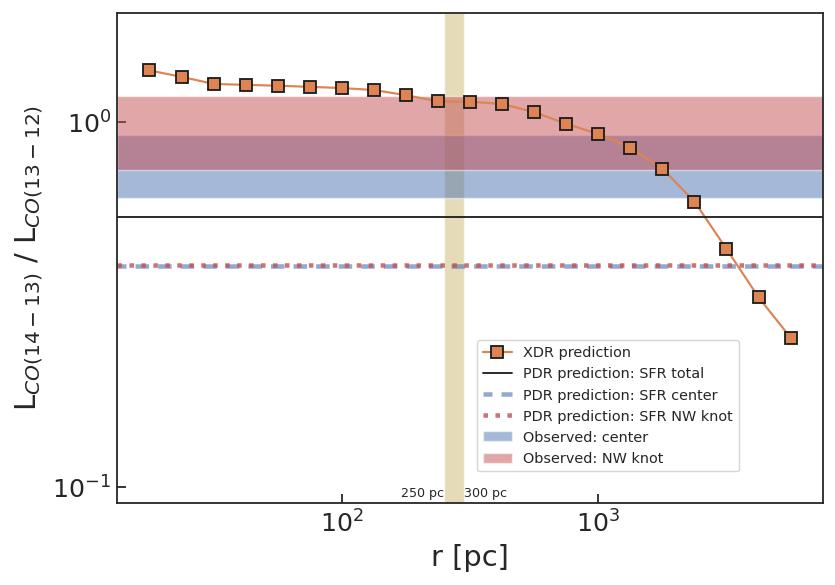

In [6]:
xdr14_13 = xdr_gmc['CO14'] / xdr_gmc['CO13']
pdr14_13 = pdr_gmc['CO14'] / pdr_gmc['CO13']

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(rX/pc, xdr14_13, 's-', ms=7, mec='k', label=r'XDR prediction', c='C1')

# add PDR predictions at fixed radii
ax.axhline(pdr14_13[gtot], ls='-', lw=1, alpha=1, color='k', label='PDR prediction: SFR total')
ax.axhline(pdr14_13[gctr], ls=(1, (3, 2)), lw=2.5, alpha=.6, color='b', label='PDR prediction: SFR center')
ax.axhline(pdr14_13[gnwk], ls=':', lw=2.5, alpha=.8, color='r', label='PDR prediction: SFR NW knot')

# add rectangle between 250 and 300 pc
ax.axvspan(xmin=250, xmax=300, alpha=.5, fc='y')
ax.text(s='250 pc', x=250, y=.94e-1, ha='right', size=7)
ax.text(s='300 pc', x=300, y=.94e-1, ha='left', size=7)

# add observed CO(14-13) / CO(13-12) ratios
ax.axhspan(ymin=0.77-0.15, ymax=0.77+0.15, alpha=.5, fc='b', label='Observed: center')
ax.axhspan(ymin=0.96-0.22, ymax=0.96+0.22, alpha=.5, fc='r', label='Observed: NW knot')

ax.set_ylim([.9e-1, 2e0])
ax.set_xlabel('r [pc]')
ax.set_ylabel(r'L$_{CO(14-13)}$ / L$_{CO(13-12)}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='lower left', fontsize=8, bbox_to_anchor=(0.5,0.05));

fig.savefig('/media/phd/collab/tadaki/J2310_CO14_CO13_predictions.png', 
            dpi=300, bbox_inches='tight')

In [50]:
# exporting a csv file with the plot data
xdr14_13 = xdr_gmc['CO14'] / xdr_gmc['CO13']
xdr14_13.index = np.round(np.log10(rX/pc), 3)
xdr14_13.sort_index().to_csv('/media/phd/collab/tadaki/xdr14_13.csv', index_label='logRpc', header=['CO14/13'])

pdr14_13 = pdr_gmc['CO14'] / pdr_gmc['CO13']
pdr14_13.index = [float(g[1:])/1e2 for g in pdr14_13.index]
pdr14_13.to_csv('/media/phd/collab/tadaki/pdr14_13.csv', index_label='logG0', header=['CO14/13'])

***
<a class="anchor" id="gmccomparison"></a>

# Comparing different GMCs

([back to top](#toc))

In [286]:
# list the available extractions
for f in sorted(os.listdir('./J2310/')): print(f)

GMC_n1000_R5pc_M20_20K
GMC_n1000_R5pc_M20_20K.csv
GMC_n102_R16pc_M20_20K
GMC_n102_R16pc_M20_20K.csv
GMC_n300_R15pc_M10_20K
GMC_n300_R15pc_M10_20K.csv
J2310_Tadaki_v20220315.pdf


In [287]:
pdr_GMCs, xdr_GMCs = [], []
for ndf_name in ['GMC_n102_R16pc_M20_20K', 'GMC_n300_R15pc_M10_20K', 'GMC_n1000_R5pc_M20_20K']:
    wd = './J2310/' + ndf_name + '/'
    ndf = pd.read_csv('./J2310/' + ndf_name + '.csv')
    pdr_df, xdr_df = [], []
    for f in sorted(os.listdir(wd)):
        this_extra = pd.read_csv(wd + f, index_col=0)
        logR_cm = ndf.loc[int(f[-6:-4]), 'logR'] + np.log10(pc)
        if 'PDR' in f: pdr_df.append(this_extra * 2*np.pi*(10**logR_cm)**2 / lsun)
        if 'XDR' in f: xdr_df.append(this_extra * 2*np.pi*(10**logR_cm)**2 / lsun)

    pdr_GMCs.append(sum(pdr_df))
    xdr_GMCs.append(sum(xdr_df))

In [299]:
# line ratios
xdr14_13 = [(xdr_gmc['CO14'] / xdr_gmc['CO13']).to_numpy() for xdr_gmc in xdr_GMCs]
pdr14_13 = [(pdr_gmc['CO14'] / pdr_gmc['CO13']).to_numpy() for pdr_gmc in pdr_GMCs]

# XDR radii
LX = 7e44 # erg/s
logFX = [float(x[1:])/1e2 for x in xdr_GMCs[0].index]
rX = np.sqrt(LX / (4 * np.pi * 10**np.array(logFX)))

# PDR radii
LFUV = 1e9 * lsun
logFFUV = [float(g0[1:])/1e2 - 2.8 for g0 in pdr_GMCs[0].index]
rP = np.sqrt(LFUV / (4 * np.pi * 10**np.array(logFFUV)))

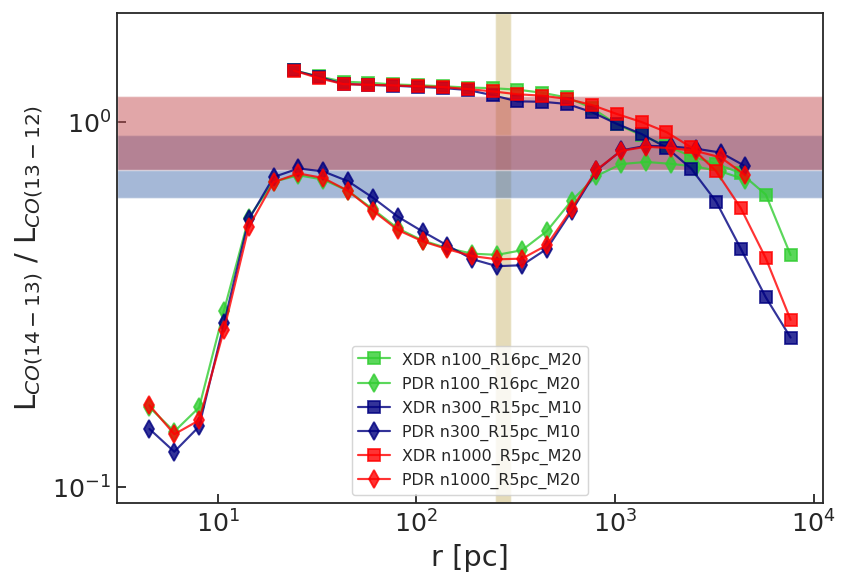

In [308]:
fig, ax = plt.subplots(figsize=(7,5))
gmclist = ['n100_R16pc_M20', 'n300_R15pc_M10', 'n1000_R5pc_M20']
colorlist = ['limegreen', 'navy', 'red']
for i, c, gmc in zip(range(len(xdr_GMCs)), colorlist, gmclist):
    ax.plot(rX/pc, xdr14_13[i], 's-', ms=7, color=c, label='XDR ' + gmc, alpha=.8)
    ax.plot(rP/pc, pdr14_13[i], 'd-', ms=7, color=c, label='PDR ' + gmc, alpha=.8)

# add rectangle between 250 and 300 pc
ax.axvspan(xmin=250, xmax=300, alpha=.5, fc='y')

# add observed CO(14-13) / CO(13-12) ratios
ax.axhspan(ymin=0.77-0.15, ymax=0.77+0.15, alpha=.5, fc='b')
ax.axhspan(ymin=0.96-0.22, ymax=0.96+0.22, alpha=.5, fc='r')

ax.set_ylim([.9e-1, 2e0])
ax.set_xlabel('r [pc]')
ax.set_ylabel(r'L$_{CO(14-13)}$ / L$_{CO(13-12)}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='lower center');

***
<a class="anchor" id="gmcspace"></a>

# Filling the galaxy with GMCs
([back to top](#toc))

The [CII] emission is represented by an exponential disk with $R_e = 1.57$ kpc and $R_d = R_e / 1.68 = 0.93$ kpc. Since the total gas mass is $M_{gas,tot} = 4.3 \times 10^{10}$ M$_{\odot}$, the radial profile, $\Sigma(R) = \Sigma(0) \, e^{-R/R_d}$, has $\Sigma(0) = 7818$ M$_{\odot}$ pc$^{-2}$. In fact:

$$
\begin{align}
M_{tot} &= \int_{0}^{2 \pi} \int_0^{+\infty} R \, \Sigma(R) \, dR \, d\theta = 
2 \pi \Sigma(0) \int_0^{+\infty}  R \, e^{-R/R_d} \, dR = \\
&= 2 \pi \Sigma(0) \, \left[ - R_d \, e^{-R/R_d} (R_d + R) \right]_0^{+ \infty} = 2 \pi \Sigma(0) \, R_d^2
= 4.25 \times 10^{10} \; \; M_{\odot}
\end{align}
$$

In [17]:
np.exp(-1.68)*(2.68)

0.4994822557856188

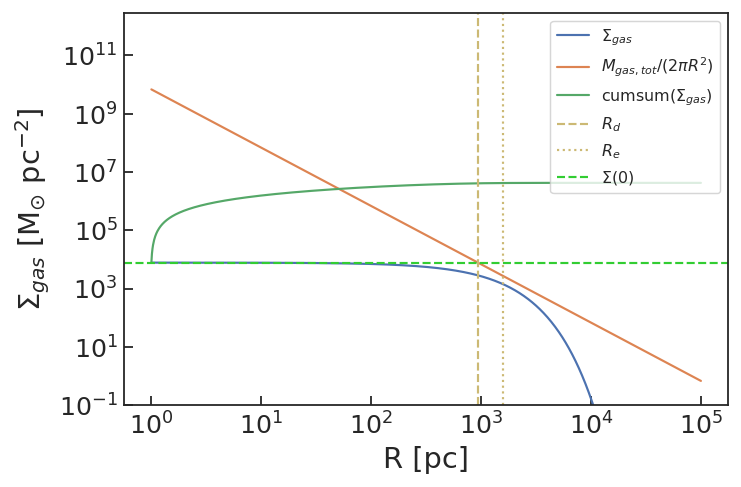

In [2]:
radii = np.logspace(0, 5, 1000)
Sigma0 = 7818
Mgastot = 4.3e10
Rd = 930
Re = 1570
SigmaR = Sigma0 * np.exp(-radii/Rd)
plt.loglog(radii, SigmaR, label=r'$\Sigma_{gas}$')
plt.loglog(radii, Mgastot/(2*np.pi*radii**2), label=r'$M_{gas,tot}/(2 \pi R^2)$')
plt.loglog(radii, np.cumsum(SigmaR), label=r'cumsum($\Sigma_{gas}$)')
plt.axvline(Rd, label=r'$R_d$', c='y', ls='dashed')
plt.axvline(Re, label=r'$R_e$', c='y', ls='dotted')
plt.axhline(Sigma0, label=r'$\Sigma(0)$', c='limegreen', ls='dashed')
plt.xlabel('R [pc]')
plt.ylabel(r'$\Sigma_{gas}$ [M$_{\odot}$ pc$^{-2}$]')
plt.ylim(bottom=1e-1)
plt.legend();

In [11]:
SigmaR

array([7.80959807e+03, 7.80950073e+03, 7.80940227e+03, 7.80930267e+03,
       7.80920191e+03, 7.80909999e+03, 7.80899689e+03, 7.80889259e+03,
       7.80878709e+03, 7.80868037e+03, 7.80857241e+03, 7.80846320e+03,
       7.80835272e+03, 7.80824097e+03, 7.80812793e+03, 7.80801357e+03,
       7.80789789e+03, 7.80778087e+03, 7.80766250e+03, 7.80754276e+03,
       7.80742163e+03, 7.80729910e+03, 7.80717515e+03, 7.80704976e+03,
       7.80692293e+03, 7.80679462e+03, 7.80666484e+03, 7.80653354e+03,
       7.80640073e+03, 7.80626639e+03, 7.80613048e+03, 7.80599301e+03,
       7.80585394e+03, 7.80571327e+03, 7.80557096e+03, 7.80542701e+03,
       7.80528140e+03, 7.80513410e+03, 7.80498509e+03, 7.80483436e+03,
       7.80468189e+03, 7.80452765e+03, 7.80437162e+03, 7.80421379e+03,
       7.80405414e+03, 7.80389264e+03, 7.80372927e+03, 7.80356401e+03,
       7.80339683e+03, 7.80322773e+03, 7.80305666e+03, 7.80288362e+03,
       7.80270858e+03, 7.80253151e+03, 7.80235239e+03, 7.80217120e+03,
      